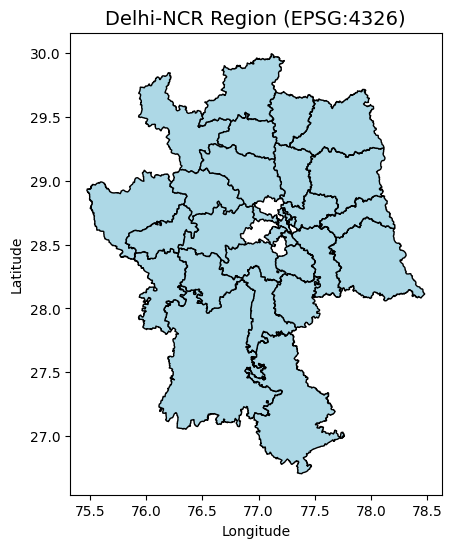

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
Delhi_ncr = gpd.read_file("/content/delhi_ncr_region.geojson")

# Plotting
fig, ax = plt.subplots(figsize=(6,6))
Delhi_ncr.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title("Delhi-NCR Region (EPSG:4326)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


In [21]:
!pip install leafmap
import leafmap

airshed = gpd.read_file("/content/delhi_airshed.geojson")

m = leafmap.Map(center=[28.6, 77.2], zoom=9)
m.add_basemap("SATELLITE")
m.add_gdf(airshed, layer_name="Delhi Airshed", style={"color": "red", "fillOpacity": 0})
m


Map(center=[28.6, 77.2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [24]:
!pip install localtileserver


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.0/270.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 14.4 MB/s eta 0:00:00


In [27]:
import leafmap
import geopandas as gpd
import glob
import os

# Load airshed GeoJSON
airshed = gpd.read_file("/content/delhi_airshed.geojson")
m = leafmap.Map(center=[28.6, 77.2], zoom=10)
m.add_basemap("SATELLITE")

m.add_gdf(airshed, layer_name="Delhi Airshed", style={"color": "red", "fillOpacity": 0})

tile_folder = "/content/drive/MyDrive/tiles_1280_centered"
tiles = glob.glob(os.path.join(tile_folder, "*.tif"))
for t in tiles[:4]:
    m.add_raster(t, layer_name=os.path.basename(t))

m


Map(center=[28.50561, 77.34440699999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

In [31]:
import os

tile_folder = "/content/drive/MyDrive/tiles_1280_centered"
tiles = glob.glob(os.path.join(tile_folder, "*.tif"))
print(f"Total number of downloaded Sentinel-2 tiles: {len(tiles)}")


Total number of downloaded Sentinel-2 tiles: 4


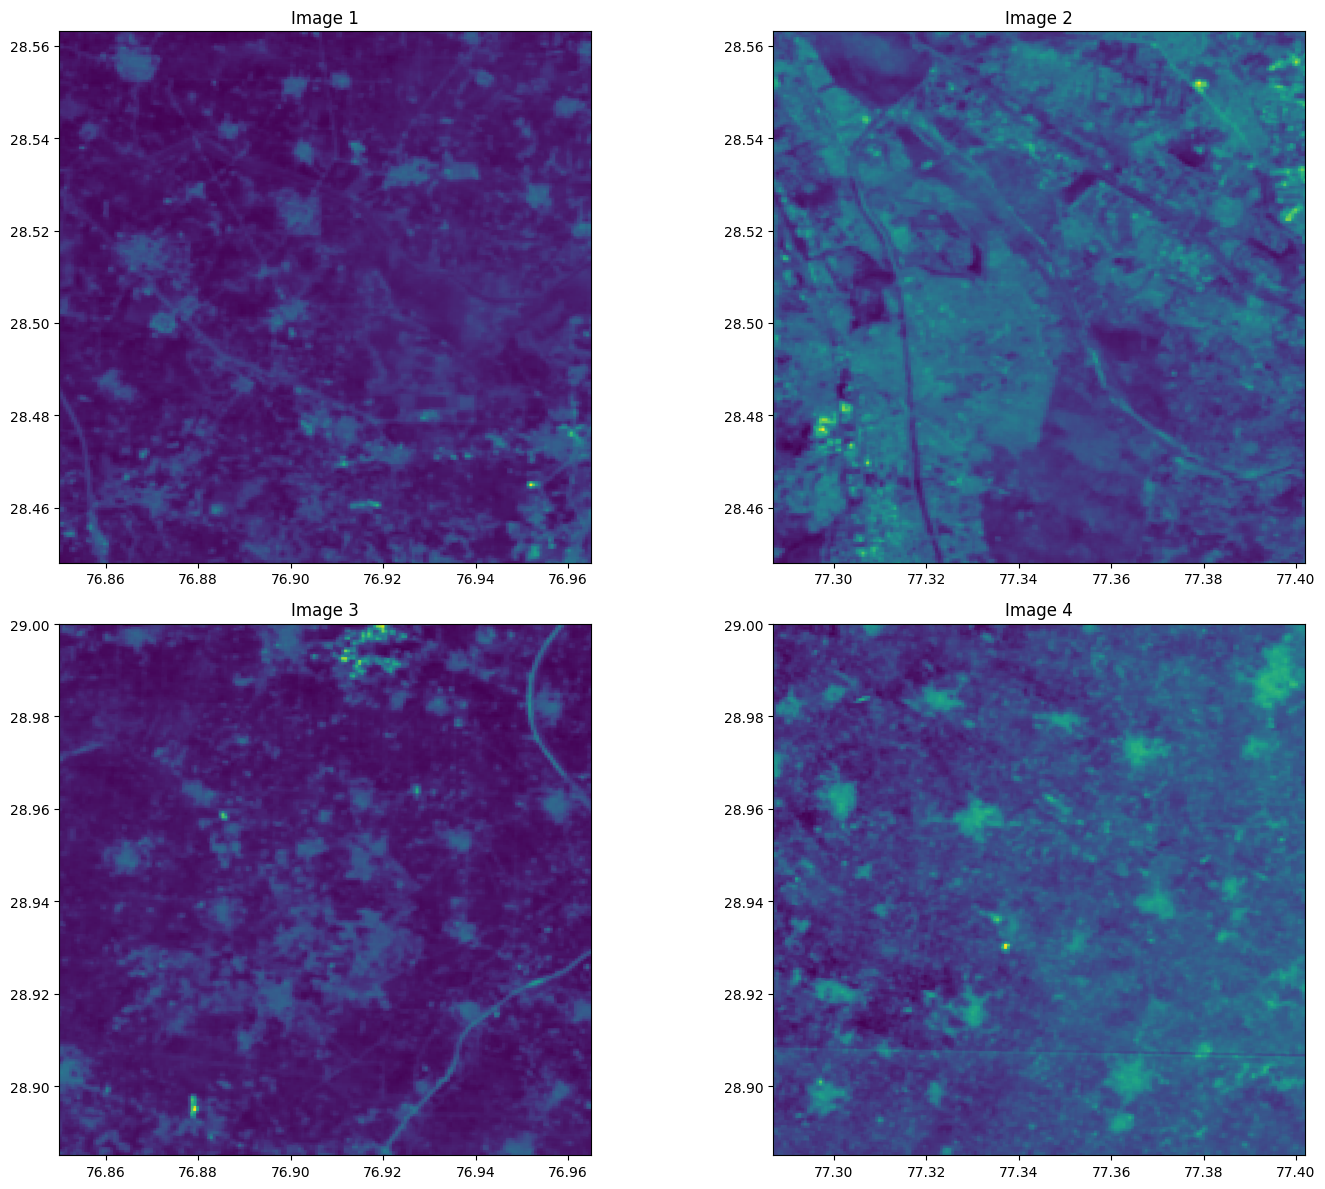

In [46]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

files = ['/content/drive/MyDrive/tiles_1280_centered/tile_28.5056_76.9075.tif', '/content/drive/MyDrive/tiles_1280_centered/tile_28.5056_77.3445.tif', '/content/drive/MyDrive/tiles_1280_centered/tile_28.9425_76.9075.tif', '/content/drive/MyDrive/tiles_1280_centered/tile_28.9425_77.3445.tif']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for i, file in enumerate(files):
    with rasterio.open(file) as src:
        ax = axes[i//2, i%2]
        show(src, ax=ax)
        ax.set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

Atmospheric conditions, particularly cloud cover percentage, significantly impact data usability by obscuring ground features and introducing noise. The acquisition date and solar geometry parameters affect illumination conditions and shadow patterns, which can influence spectral signatures and analytical outcomes. Processing level determines the degree of geometric and atmospheric correction applied, with higher-level products reducing preprocessing burdens but potentially limiting customization. Radiometric resolution governs the sensitivity to reflectance variations, where higher bit depth preserves subtle spectral differences crucial for quantitative analysis. Geographic coverage must encompass the study area with adequate buffer to accommodate geolocation uncertainties. These parameters collectively determine the imagery's fitness for purpose across diverse research domains including land use mapping, environmental monitoring, and disaster assessment. Other parameters include spatial resolution and temporal resolution.

#Label Construction & Dataset Preparation

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 105.2 MB/s eta 0:00:00


In [2]:
import rasterio
from rasterio.windows import Window
from rasterio.transform import rowcol
import pandas as pd
import random
import glob
import os
import geopandas as gpd
import numpy as np

In [6]:
print("Raster bounds:", src.bounds)
print("Boundary bounds:", boundary.total_bounds)


Raster bounds: BoundingBox(left=76.84991666666667, bottom=28.2, right=77.65008333333334, top=29.0)
Boundary bounds: [75.47339618 26.70606228 78.47747708 29.99343912]


Text(0.5, 1.0, 'Land Cover Map')

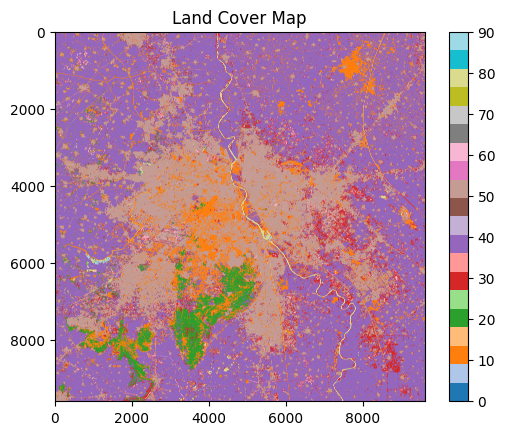

In [11]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("/content/drive/MyDrive/worldcover_bbox_delhi_ncr_2021.tif") as src:
    lc = src.read(1)
plt.imshow(lc, cmap='tab20')
plt.colorbar()
plt.title("Land Cover Map")


Edge case handling:

No-data pixels were removed and patched with no-data values were skipped.
“Unknown” ESA codes were ignored, ensuring only valid land cover classes were used.

Train-test split:
A 60/40 random split (train_test_split) was performed.
The split was stratified by class to preserve proportinal class distribution.

Class distribution:
A bar plot visualized land cover class counts.
We can see that the dataset is imbalanced with cropland dominating the graph. We'll have to implement focal loss or dice loss accordingly for this.

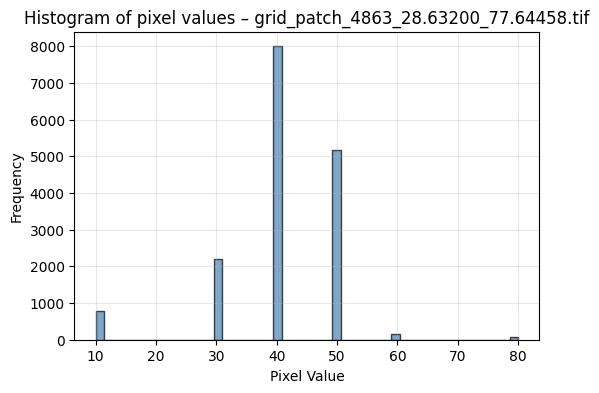

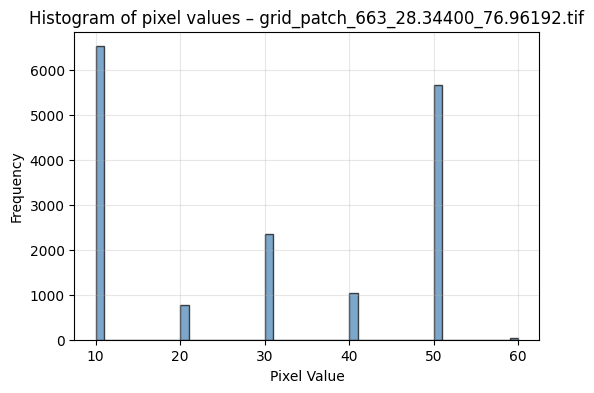

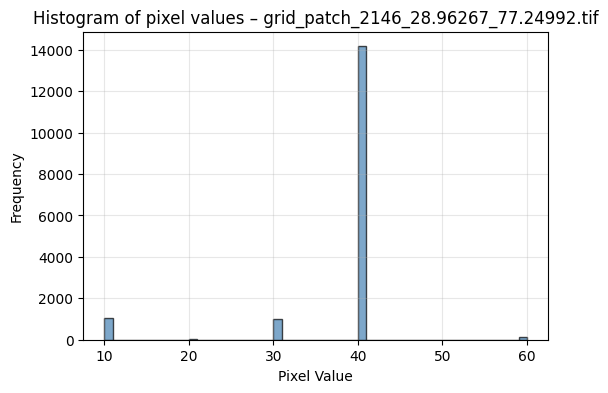

In [9]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Folder containing your patches
patch_dir = "/content/delhi_patches_grid_128x128"

# Pick a few random patch files
patches = random.sample(os.listdir(patch_dir), 3)

for p in patches:
    patch_path = os.path.join(patch_dir, p)
    with rasterio.open(patch_path) as src:
        img = src.read(1).astype(float)
        nodata = src.nodata
        if nodata is not None:
            img = img[img != nodata]
        flat = img.flatten()

        plt.figure(figsize=(6, 4))
        plt.hist(flat, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        plt.title(f"Histogram of pixel values – {p}")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.3)
        plt.show()


Since each pixel is a discrete label, I am not preprocessing it.

In [43]:
print("Unique labels:", np.unique(train_df["label"]))
print("Number of classes:", num_classes)


Unique labels: ['Built-up' 'Cropland' 'Grassland' 'Shrubland' 'Tree cover' 'Water'
 'Wetland']
Number of classes: 7


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 79.8 MB/s eta 0:00:00


/tmp/ipython-input-306931221.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if not point.within(boundary.unary_union)[0]:


Saved grid_patch_1_28.20533_76.85525.tif
Saved grid_patch_2_28.21600_76.85525.tif
Saved grid_patch_3_28.22667_76.85525.tif
Saved grid_patch_4_28.23733_76.85525.tif
Saved grid_patch_5_28.24800_76.85525.tif
Saved grid_patch_6_28.25867_76.85525.tif
Saved grid_patch_7_28.26933_76.85525.tif
Saved grid_patch_8_28.28000_76.85525.tif
Saved grid_patch_9_28.29067_76.85525.tif
Saved grid_patch_10_28.30133_76.85525.tif
Saved grid_patch_11_28.31200_76.85525.tif
Saved grid_patch_12_28.32267_76.85525.tif
Saved grid_patch_13_28.33333_76.85525.tif
Saved grid_patch_14_28.34400_76.85525.tif
Saved grid_patch_15_28.35467_76.85525.tif
Saved grid_patch_16_28.36533_76.85525.tif
Saved grid_patch_17_28.37600_76.85525.tif
Saved grid_patch_18_28.38667_76.85525.tif
Saved grid_patch_19_28.39733_76.85525.tif
Saved grid_patch_20_28.40800_76.85525.tif
Saved grid_patch_21_28.41867_76.85525.tif
Saved grid_patch_22_28.42933_76.85525.tif
Saved grid_patch_23_28.44000_76.85525.tif
Saved grid_patch_24_28.45067_76.85525.tif
S

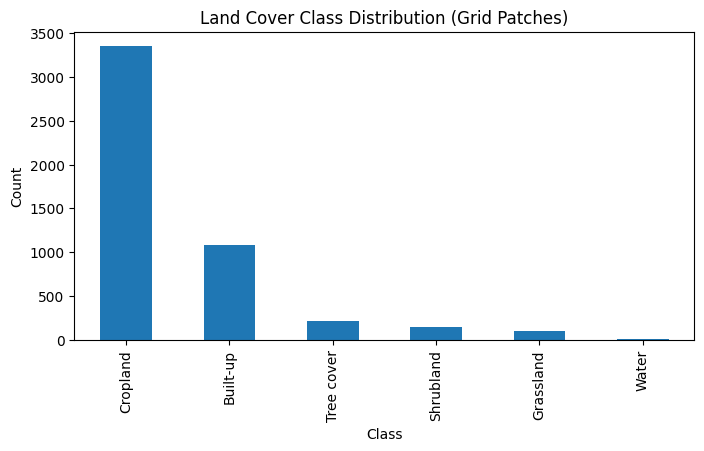

Train: (2936, 3) Test: (1958, 3)


In [3]:
import os, numpy as np, geopandas as gpd, rasterio, pandas as pd, matplotlib.pyplot as plt
from rasterio.windows import Window
from rasterio.transform import rowcol
from scipy import stats
from shapely.geometry import box
from sklearn.model_selection import train_test_split

raster_path="/content/drive/MyDrive/worldcover_bbox_delhi_ncr_2021.tif"
boundary_path="/content/drive/MyDrive/delhi_ncr_region.geojson"
output_dir="delhi_patches_grid_128x128"
os.makedirs(output_dir, exist_ok=True)

boundary = gpd.read_file(boundary_path)
with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    boundary = boundary.to_crs(raster_crs)
    left, bottom, right, top = src.bounds
    xres, yres = src.res

    raster_box = box(left, bottom, right, top)
    boundary = boundary.clip(raster_box)

    half = 64
    step_x = 128 * xres
    step_y = 128 * abs(yres)
    xs = np.arange(left + half * xres, right - half * xres, step_x)
    ys = np.arange(bottom + half * abs(yres), top - half * abs(yres), step_y)

    patch_info = []
    patch_count = 0

    for x in xs:
        for y in ys:
            point = gpd.GeoSeries.from_xy([x], [y], crs=raster_crs)
            if not point.within(boundary.unary_union)[0]:
                continue
            r, c = rowcol(src.transform, x, y)
            if (r - half < 0 or c - half < 0 or r + half > src.height or c + half > src.width):
                continue

            window = Window(c - half, r - half, 128, 128)
            patch = src.read(1, window=window)
            nodata = src.nodata
            valid = patch[patch != nodata]
            if valid.size == 0:
                continue

            mode_val = int(stats.mode(valid, axis=None, keepdims=False)[0])
            esa_to_label = {
    10: "Tree cover", 20: "Shrubland", 30: "Grassland",
    40: "Cropland", 50: "Built-up", 60: "Bare/sparse",
    70: "Snow/ice", 80: "Water", 90: "Wetlands",
    95: "Mangroves", 100: "Moss and lichen"
}

            label = esa_to_label.get(mode_val, "Unknown")
            if label == "Unknown":
                continue

            patch_name = f"grid_patch_{patch_count+1}_{y:.5f}_{x:.5f}.tif"
            patch_path = os.path.join(output_dir, patch_name)

            profile = src.profile
            profile.update({"height":128, "width":128, "transform":src.window_transform(window)})
            with rasterio.open(patch_path, "w", **profile) as dst:
                dst.write(patch, 1)

            patch_info.append({"file": patch_name, "esa_code": mode_val, "label": label})
            patch_count += 1
            print(f"Saved {patch_name}")

print(f"Done. Extracted {patch_count} patches.")

df = pd.DataFrame(patch_info)
if df.empty:
    print("No valid patches found. Check raster values or CRS overlap.")
else:
    df = df[df["label"] != "Unknown"]
    df = df.groupby("label").filter(lambda x: len(x) > 1)
    train, test = train_test_split(df, test_size=0.4, random_state=42, stratify=df["label"])
    train.to_csv("train_split.csv", index=False)
    test.to_csv("test_split.csv", index=False)

    plt.figure(figsize=(8,4))
    df["label"].value_counts().plot(kind="bar")
    plt.title("Land Cover Class Distribution (Grid Patches)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

    print("Train:", train.shape, "Test:", test.shape)

#Model Training & Supervised Evaluation

In [4]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 14.4 MB/s eta 0:00:00


Train classes: ['Built-up', 'Cropland', 'Grassland', 'Shrubland', 'Tree cover', 'Water']
Test classes: ['Built-up', 'Cropland', 'Grassland', 'Shrubland', 'Tree cover', 'Water']
Train label distribution:
label_code
0     125
1      88
2      63
3    2009
4     648
6       3
Name: count, dtype: int64
Test label distribution:
label_code
0      84
1      58
2      42
3    1340
4     432
6       2
Name: count, dtype: int64
Using device: cpu
Found 2936 valid files out of 2936
Found 1958 valid files out of 1958
Final train dataset size: 2936
Final test dataset size: 1958
Starting training...
Epoch 1/5, Loss: 0.4150
Epoch 2/5, Loss: 0.2282
Epoch 3/5, Loss: 0.1536
Epoch 4/5, Loss: 0.1164
Epoch 5/5, Loss: 0.0804
Training completed. Starting evaluation...
Test Accuracy: 0.9377
Test F1 Score: 0.9371


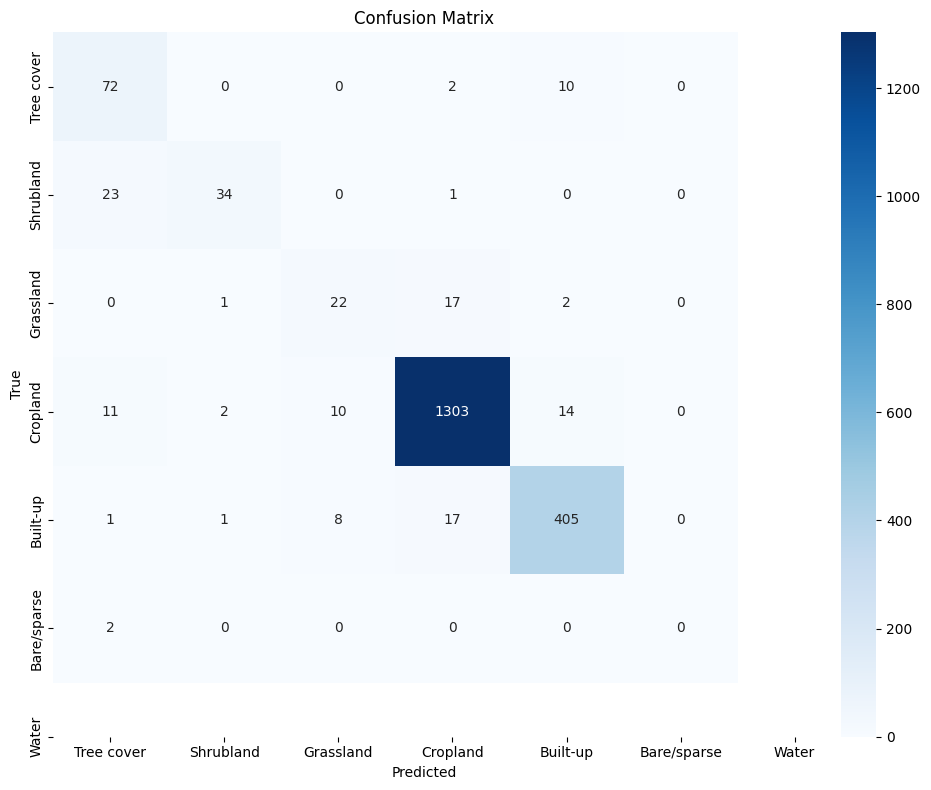

Model saved successfully


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import pandas as pd
import numpy as np
import rasterio
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("train_split.csv")
test_df = pd.read_csv("test_split.csv")

print("Train classes:", sorted(train_df['label'].unique()))
print("Test classes:", sorted(test_df['label'].unique()))

landcover_label_map = {
    "Tree cover": 0,
    "Shrubland": 1,
    "Grassland": 2,
    "Cropland": 3,
    "Built-up": 4,
    "Bare/sparse": 5,
    "Water": 6
}

train_df = train_df[train_df['label'].isin(landcover_label_map.keys())].copy()
test_df = test_df[test_df['label'].isin(landcover_label_map.keys())].copy()

train_df['label_code'] = train_df['label'].map(landcover_label_map)
test_df['label_code'] = test_df['label'].map(landcover_label_map)

print("Train label distribution:")
print(train_df['label_code'].value_counts().sort_index())
print("Test label distribution:")
print(test_df['label_code'].value_counts().sort_index())

num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LandCoverDataset(torch.utils.data.Dataset):
    def __init__(self, df, root_dir):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.valid_indices = []

        for idx in range(len(self.df)):
            file = self.df.iloc[idx]["file"]
            path = os.path.join(self.root_dir, file)
            if os.path.exists(path):
                self.valid_indices.append(idx)

        print(f"Found {len(self.valid_indices)} valid files out of {len(self.df)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        file = self.df.iloc[actual_idx]["file"]
        label = self.df.iloc[actual_idx]["label_code"]
        path = os.path.join(self.root_dir, file)

        with rasterio.open(path) as src:
            img = src.read().astype(np.float32)

        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        elif img.shape[0] > 3:
            img = img[:3]

        img = np.clip(img, 0, 10000) / 10000.0
        img = torch.tensor(img, dtype=torch.float32)
        label = torch.tensor(int(label), dtype=torch.long)

        return img, label

train_dataset = LandCoverDataset(train_df, "delhi_patches_grid_128x128")
test_dataset = LandCoverDataset(test_df, "delhi_patches_grid_128x128")

print(f"Final train dataset size: {len(train_dataset)}")
print(f"Final test dataset size: {len(test_dataset)}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

model = models.resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Starting training...")
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    batch_count = 0

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        if labels.max() >= num_classes:
            print(f"Skipping batch {batch_idx}: invalid label {labels.max()}")
            continue

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_count += 1

    if batch_count > 0:
        avg_loss = total_loss / batch_count
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

print("Training completed. Starting evaluation...")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

if len(all_preds) > 0:
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    class_names = list(landcover_label_map.keys())

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("No valid predictions for evaluation")

torch.save(model.state_dict(), "landcover_model.pth")
print("Model saved successfully")

With 1303 accurate predictions and only a few misunderstandings with Built-up and Grassland, the graphic clearly shows how well the algorithm works for Cropland. A tiny percentage of built-up areas are mistakenly labeled as grassland or cropland, but most are correctly classified (405). Shrubland and tree cover, however, exhibit a substantial degree of uncertainty. The obvious categorization of grassland into built-up and cropland suggests that these classifications overlap spectrally or texturally. Due to their extremely small sample sizes, the Sparse and Water classes are not well represented in the matrix. The model performs well overall for dominating classes like Cropland and Built-up, but it has trouble distinguishing across vegetation-related classes, which may call for better feature differentiation or class balance.

Total predictions: 1958
Correct: 1836
Incorrect: 122


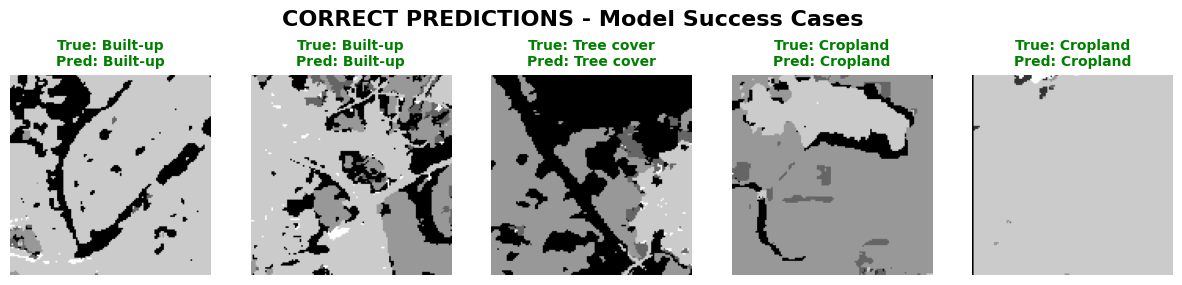

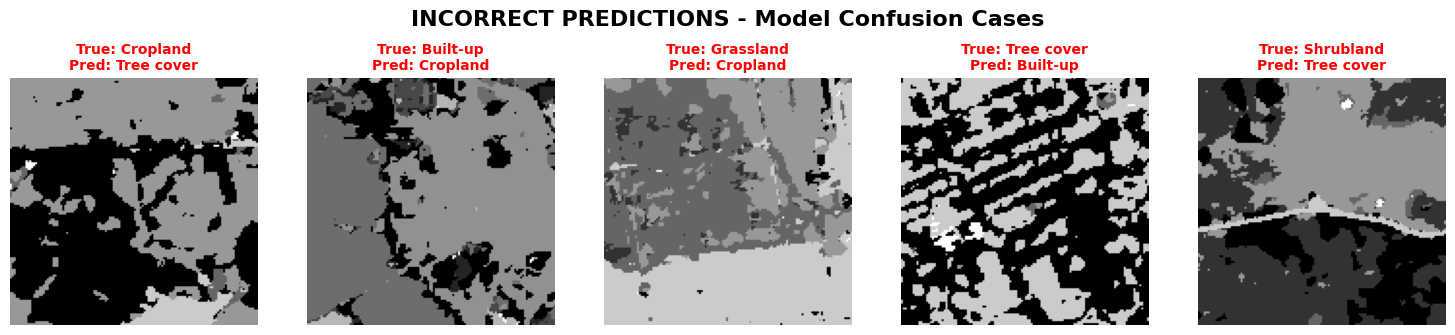


Class Labels Reference:
0: Tree cover
1: Shrubland
2: Grassland
3: Cropland
4: Built-up
5: Bare/sparse
6: Water


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

correct_indices = []
incorrect_indices = []

for i in range(len(all_labels)):
    if all_labels[i] == all_preds[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

print(f"Total predictions: {len(all_labels)}")
print(f"Correct: {len(correct_indices)}")
print(f"Incorrect: {len(incorrect_indices)}")

# Function to display image with color enhancement
def show_image(img):
    if torch.is_tensor(img):
        img_np = img.numpy().transpose(1, 2, 0)
    else:
        img_np = img.transpose(1, 2, 0)

    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    if img_np.shape[2] == 1:
        plt.imshow(img_np.squeeze(), cmap='Spectral')
    else:
        plt.imshow(img_np)

# Plot correct predictions
plt.figure(figsize=(15, 6))
plt.suptitle('CORRECT PREDICTIONS - Model Success Cases', fontsize=16, fontweight='bold')

for i, idx in enumerate(correct_indices[:5]):
    img, true_label = test_dataset[idx]
    plt.subplot(2, 5, i+1)
    show_image(img)
    plt.axis('off')

    true_class = class_names[true_label]
    pred_class = class_names[all_preds[idx]]
    plt.title(f'True: {true_class}\nPred: {pred_class}',
              color='green', fontsize=10, fontweight='bold')

# Plot incorrect predictions
plt.figure(figsize=(15, 6))
plt.suptitle('INCORRECT PREDICTIONS - Model Confusion Cases', fontsize=16, fontweight='bold')

for i, idx in enumerate(incorrect_indices[:5]):
    img, true_label = test_dataset[idx]
    plt.subplot(2, 5, i+1)
    show_image(img)
    plt.axis('off')

    true_class = class_names[true_label]
    pred_class = class_names[all_preds[idx]]
    plt.title(f'True: {true_class}\nPred: {pred_class}',
              color='red', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClass Labels Reference:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")


In [13]:
import torch
from torchmetrics import F1Score
from sklearn.metrics import f1_score
import numpy as np

print("=== F1 SCORE EVALUATION & COMPARISON ===\n")

# Convert to tensors for torchmetrics
y_true_tensor = torch.tensor(all_labels, dtype=torch.int)
y_pred_tensor = torch.tensor(all_preds, dtype=torch.int)

print(f"Total samples: {len(all_labels)}")
print(f"Unique true labels: {torch.unique(y_true_tensor)}")
print(f"Unique predictions: {torch.unique(y_pred_tensor)}")

# Find which classes are actually present
present_classes = torch.unique(torch.cat([y_true_tensor, y_pred_tensor]))
print(f"Classes present in data: {present_classes}")

# Calculate F1 scores using torchmetrics
print("\n--- TorchMetrics F1 Scores ---")
torch_f1_macro = F1Score(task="multiclass", num_classes=num_classes, average='macro')
torch_f1_weighted = F1Score(task="multiclass", num_classes=num_classes, average='weighted')
torch_f1_per_class = F1Score(task="multiclass", num_classes=num_classes, average='none')

f1_macro_torch = torch_f1_macro(y_pred_tensor, y_true_tensor)
f1_weighted_torch = torch_f1_weighted(y_pred_tensor, y_true_tensor)
f1_per_class_torch = torch_f1_per_class(y_pred_tensor, y_true_tensor)

print(f"Macro F1: {f1_macro_torch:.4f}")
print(f"Weighted F1: {f1_weighted_torch:.4f}")

print("\nPer-class F1 scores (TorchMetrics):")
for i, score in enumerate(f1_per_class_torch):
    print(f"  {class_names[i]}: {score:.4f}")

# Calculate F1 scores using sklearn
print("\n--- Scikit-learn F1 Scores ---")
f1_macro_sklearn = f1_score(all_labels, all_preds, average='macro', zero_division=0)
f1_weighted_sklearn = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
f1_per_class_sklearn = f1_score(all_labels, all_preds, average=None, zero_division=0)

print(f"Macro F1: {f1_macro_sklearn:.4f}")
print(f"Weighted F1: {f1_weighted_sklearn:.4f}")

print("\nPer-class F1 scores (Scikit-learn):")
for i in range(len(f1_per_class_sklearn)):
    class_name = class_names[i] if i < len(class_names) else f"Class_{i}"
    print(f"  {class_name}: {f1_per_class_sklearn[i]:.4f}")

# Compare results - handle different array lengths
print("\nCOMPARISON RESULTS")
print(f"Macro F1 - TorchMetrics: {f1_macro_torch:.4f}")
print(f"Macro F1 - Scikit-learn: {f1_macro_sklearn:.4f}")
print(f"Difference: {abs(f1_macro_torch - f1_macro_sklearn):.6f}")

print(f"\nWeighted F1 - TorchMetrics: {f1_weighted_torch:.4f}")
print(f"Weighted F1 - Scikit-learn: {f1_weighted_sklearn:.4f}")
print(f"Difference: {abs(f1_weighted_torch - f1_weighted_sklearn):.6f}")

# Handle per-class comparison carefully
min_length = min(len(f1_per_class_torch), len(f1_per_class_sklearn))
per_class_differences = []
for i in range(min_length):
    diff = abs(f1_per_class_torch[i].item() - f1_per_class_sklearn[i])
    per_class_differences.append(diff)

per_class_match = all(diff < 1e-6 for diff in per_class_differences)

print(f"\nCONSISTENCY CHECK")
print(f"Macro F1 matches: {abs(f1_macro_torch - f1_macro_sklearn) < 1e-6}")
print(f"Weighted F1 matches: {abs(f1_weighted_torch - f1_weighted_sklearn) < 1e-6}")
print(f"Per-class F1 matches for {min_length} classes: {per_class_match}")

if abs(f1_macro_torch - f1_macro_sklearn) < 1e-6 and abs(f1_weighted_torch - f1_weighted_sklearn) < 1e-6:
    print("Core F1 scores match between TorchMetrics and Scikit-learn")
else:
    print("Some differences detected between implementations")

# Additional metrics for comprehensive evaluation
from torchmetrics import Precision, Recall, Accuracy

print("\n=== ADDITIONAL TORCHMETRICS ===")
precision = Precision(task="multiclass", num_classes=num_classes, average='weighted')
recall = Recall(task="multiclass", num_classes=num_classes, average='weighted')
accuracy = Accuracy(task="multiclass", num_classes=num_classes)

precision_score = precision(y_pred_tensor, y_true_tensor)
recall_score = recall(y_pred_tensor, y_true_tensor)
accuracy_score = accuracy(y_pred_tensor, y_true_tensor)

print(f"Weighted Precision: {precision_score:.4f}")
print(f"Weighted Recall: {recall_score:.4f}")
print(f"Accuracy: {accuracy_score:.4f}")

# Class-wise performance analysis for present classes only
print("\nCLASS-WISE PERFORMANCE ANALYSIS")
precision_per_class = Precision(task="multiclass", num_classes=num_classes, average='none')
recall_per_class = Recall(task="multiclass", num_classes=num_classes, average='none')

precision_scores = precision_per_class(y_pred_tensor, y_true_tensor)
recall_scores = recall_per_class(y_pred_tensor, y_true_tensor)

print("\nDetailed class performance:")
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Samples':<10}")
print("-" * 55)

# Count samples per class
from collections import Counter
class_counts = Counter(all_labels)

for i in range(num_classes):
    if i in class_counts:  # Only show classes that have samples
        sample_count = class_counts[i]
        print(f"{class_names[i]:<15} {precision_scores[i]:.4f}    {recall_scores[i]:.4f}    {f1_per_class_torch[i]:.4f}    {sample_count:>8}")

# Identify best and worst performing classes (only among present classes)
present_f1_scores = [f1_per_class_torch[i].item() for i in range(num_classes) if i in class_counts]
if present_f1_scores:
    best_f1_idx = np.argmax(present_f1_scores)
    worst_f1_idx = np.argmin(present_f1_scores)

    present_class_indices = [i for i in range(num_classes) if i in class_counts]

    print(f"\nBest performing class: {class_names[present_class_indices[best_f1_idx]]} (F1: {present_f1_scores[best_f1_idx]:.4f})")
    print(f"Worst performing class: {class_names[present_class_indices[worst_f1_idx]]} (F1: {present_f1_scores[worst_f1_idx]:.4f})")

# Final summary
print("\nFINAL EVALUATION SUMMARY")
print(f"Overall Weighted F1 Score: {f1_weighted_torch:.4f}")
print(f"Overall Macro F1 Score: {f1_macro_torch:.4f}")
print(f"Overall Accuracy: {accuracy_score:.4f}")

if f1_weighted_torch > 0.8:
    performance = "Excellent"
elif f1_weighted_torch > 0.6:
    performance = "Good"
elif f1_weighted_torch > 0.4:
    performance = "Fair"
else:
    performance = "Poor"

print(f"Model Performance: {performance}")
print(f"Classes with predictions: {len(present_classes)} out of {num_classes} total classes")

=== F1 SCORE EVALUATION & COMPARISON ===

Total samples: 1958
Unique true labels: tensor([0, 1, 2, 3, 4, 6], dtype=torch.int32)
Unique predictions: tensor([0, 1, 2, 3, 4], dtype=torch.int32)
Classes present in data: tensor([0, 1, 2, 3, 4, 6], dtype=torch.int32)

--- TorchMetrics F1 Scores ---
Macro F1: 0.6503
Weighted F1: 0.9371

Per-class F1 scores (TorchMetrics):
  Tree cover: 0.7461
  Shrubland: 0.7083
  Grassland: 0.5366
  Cropland: 0.9724
  Built-up: 0.9386
  Bare/sparse: 0.0000
  Water: 0.0000

--- Scikit-learn F1 Scores ---
Macro F1: 0.6503
Weighted F1: 0.9371

Per-class F1 scores (Scikit-learn):
  Tree cover: 0.7461
  Shrubland: 0.7083
  Grassland: 0.5366
  Cropland: 0.9724
  Built-up: 0.9386
  Bare/sparse: 0.0000

COMPARISON RESULTS
Macro F1 - TorchMetrics: 0.6503
Macro F1 - Scikit-learn: 0.6503
Difference: 0.000000

Weighted F1 - TorchMetrics: 0.9371
Weighted F1 - Scikit-learn: 0.9371
Difference: 0.000000

CONSISTENCY CHECK
Macro F1 matches: True
Weighted F1 matches: True
Per